### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net2Loops.inp`. Let's start by setting up the model:

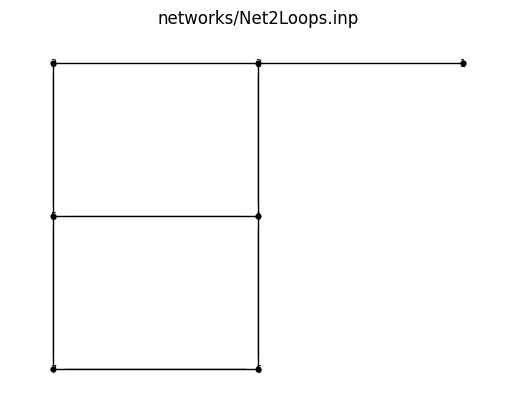

{'duration': 0.0,
 'hydraulic_timestep': 3600,
 'quality_timestep': 300,
 'rule_timestep': 360,
 'pattern_timestep': 7200,
 'pattern_start': 0.0,
 'report_timestep': 3600,
 'report_start': 0.0,
 'start_clocktime': 0.0,
 'statistic': 'NONE',
 'pattern_interpolation': False}

In [1]:
import os
from pathlib import Path
import wntr
import wntr_quantum

# Define the directory path
epanet_tmp_dir = Path("/Users/murilo/scratch_dir/.epanet_quantum")

# check if the directory exists
if not epanet_tmp_dir.exists():
    epanet_tmp_dir.mkdir(parents=True, exist_ok=True)

# set the environment variables
os.environ["EPANET_TMP"] = str(epanet_tmp_dir)
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = 'networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# explicitly set Darcy-Weisbach head loss formulas and pressure dependent demand mode
wn.options.hydraulic.headloss = 'D-W'
wn.options.hydraulic.demand_model = 'PDD'

# required pressure: the pressure above which the consumer should receive the desired demand
wn.options.hydraulic.required_pressure = 30.00 # psi (21.097 m)
# minimum pressure: this is the pressure below which the consumer cannot receive any water
wn.options.hydraulic.minimum_pressure  = 5.00  # psi (3.516 m)

# set time duration of the simulation (in seconds)
wn.options.time.duration = 0

# print options
dict(wn.options.hydraulic)
dict(wn.options.time)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [2]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

# load EPANET A and b matrices from temp
epanet_A, epanet_b = wntr_quantum.sim.epanet.load_epanet_matrix()

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/.epanet_quantum

Size of the Jacobian in EPANET simulator: 6
Size of the b vector in EPANET simulator: 6


(name          2         3          4         5          6         7  \
 0     42.140068  8.600555  28.180336  6.061879  11.256944  6.757542   
 
 name             1  
 0     4.394531e-07  ,
 name        1         2         3         4         5         6         7  \
 0     0.14645  0.015092  0.103587  0.006699  0.064794  0.018934  0.004553   
 
 name         8  
 0    -0.004205  )

### Define a helper function

Before proceeding to the proper quantum solution of the water network model, let's define a helper function. This function checks that the quantum results are within `TOL`% of those obtained classically. It also fills in lists containing the final values of pressures and flow rates obtained.

In [3]:
TOL = 5  # => per cent
DELTA = 1.0e-12

classical_res = []
quantum_res = []


def compare_results(classical_result, quantum_result):
    """
    Helper function that compares the classical and quantum simulation results.
    """
    def calculate_differences(classical_value, quantum_value):
        """Helper function to evaluate percentage difference between classical and quantum results."""
        is_close_to_classical = abs(classical_value - quantum_value) / abs(classical_value + DELTA) <= TOL / 100.0
        if is_close_to_classical:
            print(f"Quantum result {quantum_value} within {TOL}% of classical result {classical_value}")
            quantum_res.append(quantum_value)
            classical_res.append(classical_value)
        return is_close_to_classical
    
    for link in classical_result.link["flowrate"].columns:
        classical_value = classical_result.link["flowrate"][link].iloc[0]
        quantum_value = quantum_result.link["flowrate"][link].iloc[0]
        message = f"Flowrate {link}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert calculate_differences(classical_value, quantum_value), message

    for node in classical_result.node["pressure"].columns:
        classical_value = classical_result.node["pressure"][node].iloc[0]
        quantum_value = quantum_result.node["pressure"][node].iloc[0]
        message= f"Pressure {node}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert calculate_differences(classical_value, quantum_value), message

### Solve water network with `QuantumEpanetSimulator` and VQLS 

We now solve the model using VQLS. In this example, we are **preconditioning** the initial linear system using *diagonal scaling* and also using a **mix of two classical optimizers**.

In [4]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="symmetric",
    verbose=True,
    preconditioner="diagonal_scaling",
    reorder=True,
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_vqls = sim.run_sim(linear_solver=linear_solver)

compare_results(results_epanet, results_vqls)

results_vqls.node["pressure"], results_vqls.link["flowrate"]

/Users/murilo/Library/CloudStorage/OneDrive-NetherlandseScienceCenter/Documents/NLeSC_Projects/Vitens/wntr-quantum/.venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/murilo/Library/CloudStorage/OneDrive-NetherlandseScienceCenter/Documents/NLeSC_Projects/Vitens/wntr-quantum/.venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


VQLS Iteration 805 Cost 1.154e-06
   Normal return from subroutine COBYLA

   NFVALS =  805   F = 1.154141E-06    MAXCV = 0.000000E+00
   X =-2.682622E+00   1.454230E+00   3.132382E+00   1.629009E-02   1.195964E-01
       1.017855E-01   3.692687E+00  -1.386119E+00  -2.103534E-01   8.844173E-02
       2.858262E-01   2.127582E+00
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 390
         Gradient evaluations: 30
VQLS Iteration 512 Cost 1.024e-07
   Normal return from subroutine COBYLA

   NFVALS =  512   F = 1.024475E-07    MAXCV = 0.000000E+00
   X = 3.405629E+00  -1.700984E-01   2.393167E+00   3.114244E+00   3.541048E-01
      -3.056769E+00  -1.902705E+00   2.231159E-01   3.367774E+00  -2.998507E+00
       6.042482E-01  -4.831022E-01
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 247
         Gradient evaluation

(name          2         3          4        5          6         7  \
 0     42.140717  8.600239  28.180689  6.06173  11.257074  6.757468   
 
 name             1  
 0     4.394531e-07  ,
 name         1         2         3         4         5         6         7  \
 0     0.146448  0.015092  0.103589  0.006699  0.064795  0.018934  0.004553   
 
 name         8  
 0    -0.004205  )

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

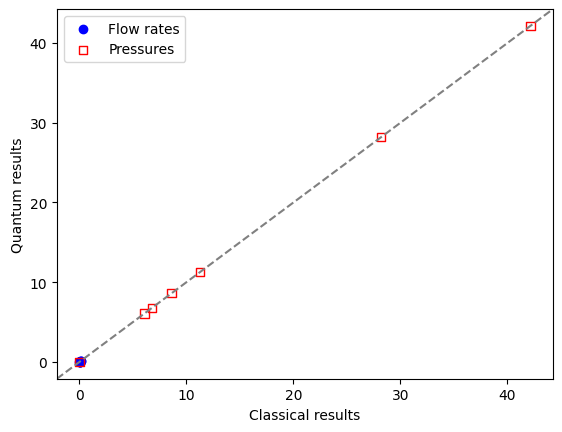

In [5]:
import matplotlib.pyplot as plt
plt.scatter(classical_res[:n_pipes], quantum_res[:n_pipes], label="Flow rates", color="blue", marker="o")
plt.scatter(classical_res[n_pipes:], quantum_res[n_pipes:], label="Pressures", color="red", marker="s", facecolors='none')
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
plt.xlabel("Classical results")
plt.ylabel("Quantum results")
plt.legend()
plt.show()